<br>
<br>
<br>

## Summary of our course of action

<br>

+ Feature 1: Past tipping behaviour <br>
   - <b>past_tipping_behaviour_%</b>: shows the past tipping behavior of the user in %. 
   - <b>past_tipping_behaviour_weighted_%</b>: shows the past tipping behavior of the user <b>in a weighted manner</b>. 
   - <b>past_tipping_behaviour_weighted_days</b>: shows the past tipping behavior of the user <b>in a weighted manner</b>
   - <b>last_order_received_tip</b>: provides information on whether or not the user gave a tip on the last order.
   - <b>mean_days_since_prior_order</b> 
   - <b>reorder_speed_score</b>: shows, if a user has reordered faster or slower than usual.



+ Feature 2: New Customer



+ Feature 3: Amount of items per order



+ Feature 4: Impact of product categories
   - <b>departments</b>
   - <b>aisles</b>
   - <b>products</b>
<br>
<br>
<br>


# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from xgboost import XGBClassifier
from pprint import pprint
from functools import reduce
import os

aisles = pd.read_csv('Data/aisles.csv')
departments = pd.read_csv('Data/departments.csv')
orders = pd.read_csv('Data/orders.csv')
products = pd.read_csv('Data/products.csv')
opp = pd.read_csv('Data/order_products__prior.csv')
opt = pd.read_csv('Data/order_products__train.csv')
op = pd.concat([opp, opt])

#contains the target ("tip") 
tips_trainingsdata = pd.read_csv('Data/tip_trainingsdaten.csv') 
tips_testdata = pd.read_csv('Data/tip_testdaten.csv') 

# Data Preparation
Remove everything, that is a relict of the kaggle.com Instacart Challenge and does not relate to the task. Then create a table that contains both tips_trainingsdata and tips_testdata to develop the features.

In [2]:
tips_trainingsdata = tips_trainingsdata.drop('Unnamed: 0', axis=1)
tips_testdata = tips_testdata.drop('Unnamed: 0', axis=1)
#del orders['eval_set']
tips = pd.concat([tips_trainingsdata, tips_testdata])

<br>
<br>

# Feature Engineering

## Feature 1: Past tipping behaviour

- Add column <b>'past_tipping_behaviour_%'</b> to the order table, which shows the past tipping behavior of the user in %. The <b>highest score</b>, that can be achieved, is <b>1</b>. The <b>lowest score</b>, that can be achieved, is <b>0</b>. 

- Add column <b>'past_tipping_behaviour_weighted_%'</b> to the order table, that shows the past tipping behavior of the user <b>in a weighted manner</b>. Tips made in the recent past have more weight, than tips in the distant past. The current order is order n. It receives the weight n / n = 1. n is the order_number. The previous order, from now onwards described as order n - 1 receives the weight (n - 1) / n and so on ...  

- Add column <b>'past_tipping_behaviour_weighted_days'</b> to the order table, that shows the past tipping behavior of the user <b>in a weighted manner</b>. Tips made in the recent past have more weight, than tips in the distant past. The current order is order n. It receives the weight ( n / n ) * ( sum_days_since_prior_order / sum_days_since_prior_order ) = 1. The previous order, from now onwards described as order n - 1 receives the weight (n - 1) / n * (( sum_days_since_prior_order - days_since_prior_order_1 ) / sum_days_since_prior_order ) and so on ...  

- Add the coulmn <b>'last_order_received_tip'</b> to the order table. This column provides information on whether or not the user gave a tip on the last order.

- Add the coulmn <b>'mean_days_since_prior_order'</b> to the order table.

- Add the coulmn <b>'reorder_speed_score'</b> to the order table, that shows, if a user has reordered faster or slower than usual.

In [3]:
orders_and_tips = orders[['eval_set', 'order_id','user_id', 'days_since_prior_order', 'order_number']].merge(tips)
orders_and_tips.head()

,eval_set,order_id,user_id,days_since_prior_order,order_number,tip
0,prior,2539329,1,NaN,1,1.0
1,prior,2398795,1,15.0,2,1.0
2,prior,473747,1,21.0,3,1.0
3,prior,2254736,1,29.0,4,1.0
4,prior,431534,1,28.0,5,1.0


**Next step:** Clone the above table 11 times. For the last 10 tables, adjust the order_number column so that the table can be merged into itself 10 times, inserting the past value in a new column in the current row. See table below.

In [4]:
# select relevant columns and rename them, if needed
orders_and_tips__1 = orders_and_tips.copy()
orders_and_tips__1 = orders_and_tips__1[['eval_set', "order_id", "user_id", "order_number",  "tip", "days_since_prior_order"]]
orders_and_tips__1.rename(columns={"tip":"tip_current_order"} ,inplace=True)
orders_and_tips__1.rename(columns={"days_since_prior_order":"days_since_prior_order_1"} ,inplace=True)

# prepare the previous order 1: select relevant columns and rename them, if needed
orders_and_tips__2 = orders_and_tips.copy()
orders_and_tips__2['order_number'] += 1
orders_and_tips__2 = orders_and_tips__2[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__2.rename(columns={"tip":"tip_1"} ,inplace=True)
orders_and_tips__2.rename(columns={"days_since_prior_order":"days_since_prior_order_2"} ,inplace=True)

# prepare the previous order of previous order 1 -> previous order 2: select relevant columns and rename them, if needed
orders_and_tips__3 = orders_and_tips.copy()
orders_and_tips__3['order_number'] += 2
orders_and_tips__3 = orders_and_tips__3[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__3.rename(columns={"tip":"tip_2"} ,inplace=True)
orders_and_tips__3.rename(columns={"days_since_prior_order":"days_since_prior_order_3"} ,inplace=True)

# prepare the previous order of previous order 2 -> previous order 3: select relevant columns and rename them, if needed
orders_and_tips__4 = orders_and_tips.copy()
orders_and_tips__4['order_number'] += 3
orders_and_tips__4 = orders_and_tips__4[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__4.rename(columns={"tip":"tip_3"} ,inplace=True)
orders_and_tips__4.rename(columns={"days_since_prior_order":"days_since_prior_order_4"} ,inplace=True)

# prepare the previous order of previous order 3 -> previous order 4: select relevant columns and rename them, if needed
orders_and_tips__5 = orders_and_tips.copy()
orders_and_tips__5['order_number'] += 4
orders_and_tips__5 = orders_and_tips__5[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__5.rename(columns={"tip":"tip_4"} ,inplace=True)
orders_and_tips__5.rename(columns={"days_since_prior_order":"days_since_prior_order_5"} ,inplace=True)

# prepare the previous order of previous order 4 -> previous order 5: select relevant columns and rename them, if needed
orders_and_tips__6 = orders_and_tips.copy()
orders_and_tips__6['order_number'] += 5
orders_and_tips__6 = orders_and_tips__6[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__6.rename(columns={"tip":"tip_5"} ,inplace=True)
orders_and_tips__6.rename(columns={"days_since_prior_order":"days_since_prior_order_6"} ,inplace=True)

# prepare the previous order of previous order 5 -> previous order 6: select relevant columns and rename them, if needed
orders_and_tips__7 = orders_and_tips.copy()
orders_and_tips__7['order_number'] += 6
orders_and_tips__7 = orders_and_tips__7[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__7.rename(columns={"tip":"tip_6"} ,inplace=True)
orders_and_tips__7.rename(columns={"days_since_prior_order":"days_since_prior_order_7"} ,inplace=True)

# prepare the previous order of previous order 6 -> previous order 7: select relevant columns and rename them, if needed
orders_and_tips__8 = orders_and_tips.copy()
orders_and_tips__8['order_number'] += 7
orders_and_tips__8 = orders_and_tips__8[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__8.rename(columns={"tip":"tip_7"} ,inplace=True)
orders_and_tips__8.rename(columns={"days_since_prior_order":"days_since_prior_order_8"} ,inplace=True)

# prepare the previous order of previous order 7 -> previous order 8: select relevant columns and rename them, if needed
orders_and_tips__9 = orders_and_tips.copy()
orders_and_tips__9['order_number'] += 8
orders_and_tips__9 = orders_and_tips__9[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__9.rename(columns={"tip":"tip_8"} ,inplace=True)
orders_and_tips__9.rename(columns={"days_since_prior_order":"days_since_prior_order_9"} ,inplace=True)

# prepare the previous order of previous order 8 -> previous order 9: select relevant columns and rename them, if needed
orders_and_tips__10 = orders_and_tips.copy()
orders_and_tips__10['order_number'] += 9
orders_and_tips__10 = orders_and_tips__10[["user_id", "order_number", "tip", "days_since_prior_order"]]
orders_and_tips__10.rename(columns={"tip":"tip_9"} ,inplace=True)
orders_and_tips__10.rename(columns={"days_since_prior_order":"days_since_prior_order_10"} ,inplace=True)

# prepare the previous order of previous order 9 -> previous order 10: select relevant columns and rename them, if needed
orders_and_tips__11 = orders_and_tips.copy()
orders_and_tips__11['order_number'] += 10
orders_and_tips__11 = orders_and_tips__11[["user_id", "order_number", "tip"]]
orders_and_tips__11.rename(columns={"tip":"tip_10"} ,inplace=True)

In [ ]:
# merge all previously created tables together
orders_and_tips = orders_and_tips__1.merge(orders_and_tips__2, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__3, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__4, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__5, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__6, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__7, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__8, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__9, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__10, on=['user_id','order_number'], how="left")
orders_and_tips = orders_and_tips.merge(orders_and_tips__11, on=['user_id','order_number'], how="left")

In [ ]:
orders_and_tips = orders_and_tips.sort_values(['user_id', 'order_number'], ascending = [True, True], inplace=False, kind='quicksort', na_position='last')
orders_and_tips.head(15)

<br><br>

**Conclusion:** 

The value of the column "tip_current_order" cannot be used to calculate each feature as it is the target value.

<br>

**Next steps:** 

- Add the ''sum_days_since_prior_order'' column that sums all values of the "days_since_prior_order" columns from "days_since_prior_order_1" to "days_since_prior_order_10"

- Before this step can be performed, all NaN's must be replaced by 0. This has no influence on the subsequent calculation

- Furthermore add the ''mean_days_since_prior_order'' column

- Add the ''reorder_speed_score'' column

- Add the column ''last_order_received_tip'' to the order table. Add column ''past_tipping_behaviour_%'' to the order table

- Add column 'past_tipping_behaviour_weighted_%' to the order table

- Add column ''past_tipping_behaviour_weighted_days'' to the order table.

In [ ]:
# dataframe to process data
orders_and_tips_x = orders_and_tips.copy()
# remove target value from the data frame
orders_and_tips_x = orders_and_tips_x.drop('tip_current_order', axis=1)
orders_and_tips_x.isna().sum()

In [ ]:
orders_and_tips_x = orders_and_tips_x.fillna(0)
orders_and_tips_x.isna().sum()

In [9]:
# sum_days_since_prior_order
orders_and_tips_x.insert(4, 'sum_days_since_prior_order', 0) # insert new column
orders_and_tips_x['sum_days_since_prior_order'] = orders_and_tips_x['days_since_prior_order_1'] + orders_and_tips_x['days_since_prior_order_2'] + orders_and_tips_x['days_since_prior_order_3'] + orders_and_tips_x['days_since_prior_order_4'] + orders_and_tips_x['days_since_prior_order_5'] + orders_and_tips_x['days_since_prior_order_6'] + orders_and_tips_x['days_since_prior_order_7'] + orders_and_tips_x['days_since_prior_order_8'] + orders_and_tips_x['days_since_prior_order_9'] + orders_and_tips_x['days_since_prior_order_10']
# one batch can contain max 10 past orders
orders_and_tips_x.insert(4, 'amount_orders_in_this_batch', 11) # insert new column
orders_and_tips_x.loc[orders_and_tips_x['order_number'] < 11,'amount_orders_in_this_batch'] = orders_and_tips_x['order_number']
orders_and_tips_x['amount_orders_in_this_batch'] = orders_and_tips_x['amount_orders_in_this_batch'] - 1
# mean_days_since_prior_order
orders_and_tips_x.insert(5, 'mean_days_since_prior_order', 0) # insert new column
orders_and_tips_x['mean_days_since_prior_order'] = orders_and_tips_x['sum_days_since_prior_order'] / orders_and_tips_x['amount_orders_in_this_batch']
# reorder_speed_score
orders_and_tips_x.insert(7, 'reorder_speed_score', 0) # insert new column
orders_and_tips_x['reorder_speed_score'] = orders_and_tips_x['days_since_prior_order_1'] / orders_and_tips_x['mean_days_since_prior_order']
# last_order_received_tip
orders_and_tips_x.insert(5, 'last_order_received_tip', 0) # insert new column
orders_and_tips_x['last_order_received_tip'] = orders_and_tips_x['tip_1']
# past_tipping_behaviour_%
orders_and_tips_x['sum_tips'] = orders_and_tips_x['tip_1'] + orders_and_tips_x['tip_2'] + orders_and_tips_x['tip_3'] + orders_and_tips_x['tip_4'] + orders_and_tips_x['tip_5'] + orders_and_tips_x['tip_6'] + orders_and_tips_x['tip_7'] + orders_and_tips_x['tip_8'] + orders_and_tips_x['tip_9'] + orders_and_tips_x['tip_10']
orders_and_tips_x.insert(9, 'past_tipping_behaviour_%', 0) # insert new column
orders_and_tips_x['past_tipping_behaviour_%'] = orders_and_tips_x['sum_tips'] /  orders_and_tips_x['amount_orders_in_this_batch']
# past_tipping_behaviour_weighted_%
orders_and_tips_x.insert(10, 'past_tipping_behaviour_weighted_%', 0) # insert new column
orders_and_tips_x['past_tipping_behaviour_weighted_%'] = (orders_and_tips_x['amount_orders_in_this_batch'] - 1) / orders_and_tips_x['amount_orders_in_this_batch'] * orders_and_tips_x['tip_1'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 2) / orders_and_tips_x['amount_orders_in_this_batch'] * orders_and_tips_x['tip_2'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 3) / orders_and_tips_x['amount_orders_in_this_batch'] * orders_and_tips_x['tip_3'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 4) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_4'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 5) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_5'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 6) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_6'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 7) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_7'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 8) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_8'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 9) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_9'] + (orders_and_tips_x['amount_orders_in_this_batch'] - 9.9) / orders_and_tips_x['amount_orders_in_this_batch'] *  orders_and_tips_x['tip_10'] 
# past_tipping_behaviour_weighted_days
orders_and_tips_x.insert(11, 'past_tipping_behaviour_weighted_days', 0) # insert new column
orders_and_tips_x['past_tipping_behaviour_weighted_days'] = orders_and_tips_x['tip_1'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1']) / (orders_and_tips_x['sum_days_since_prior_order']  + 0.1)) + orders_and_tips_x['tip_2'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2']) / (orders_and_tips_x['sum_days_since_prior_order']  + 0.1)) + orders_and_tips_x['tip_3'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_4'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_5'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_6'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5'] - orders_and_tips_x['days_since_prior_order_6']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_7'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5'] - orders_and_tips_x['days_since_prior_order_6'] - orders_and_tips_x['days_since_prior_order_7']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_8'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5'] - orders_and_tips_x['days_since_prior_order_6'] - orders_and_tips_x['days_since_prior_order_7'] - orders_and_tips_x['days_since_prior_order_8']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_9'] * ((orders_and_tips_x['sum_days_since_prior_order'] + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5'] - orders_and_tips_x['days_since_prior_order_6'] - orders_and_tips_x['days_since_prior_order_7'] - orders_and_tips_x['days_since_prior_order_8'] - orders_and_tips_x['days_since_prior_order_9']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1)) + orders_and_tips_x['tip_10'] * ((orders_and_tips_x['sum_days_since_prior_order']  + 0.1 - orders_and_tips_x['days_since_prior_order_1'] - orders_and_tips_x['days_since_prior_order_2'] - orders_and_tips_x['days_since_prior_order_3'] - orders_and_tips_x['days_since_prior_order_4'] - orders_and_tips_x['days_since_prior_order_5'] - orders_and_tips_x['days_since_prior_order_6'] - orders_and_tips_x['days_since_prior_order_7'] - orders_and_tips_x['days_since_prior_order_8'] - orders_and_tips_x['days_since_prior_order_9'] - orders_and_tips_x['days_since_prior_order_10']) / (orders_and_tips_x['sum_days_since_prior_order'] + 0.1))

In [10]:
# add target value and other values to the data frame
orders_and_tips_x = orders_and_tips_x[['order_id', 'eval_set', 'user_id', 'order_number', 'amount_orders_in_this_batch']].merge(orders_and_tips[['order_id', 'tip_current_order']]).merge(orders_and_tips_x[['order_id',  'last_order_received_tip', 'mean_days_since_prior_order', 'sum_days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_%', 'past_tipping_behaviour_weighted_days']], on=['order_id'], how="left").merge(orders_and_tips[['order_id', 'days_since_prior_order_1', 'tip_1', 'days_since_prior_order_2', 'tip_2', 'days_since_prior_order_3', 'tip_3', 'days_since_prior_order_4', 'tip_4', 'days_since_prior_order_5', 'tip_5', 'days_since_prior_order_6', 'tip_6', 'days_since_prior_order_7', 'tip_7', 'days_since_prior_order_8', 'tip_8', 'days_since_prior_order_9', 'tip_9', 'days_since_prior_order_10', 'tip_10']], on=['order_id'], how="left").merge(orders_and_tips_x[['order_id', 'sum_tips']], on=['order_id'], how="left")

In [11]:
# sort
orders_and_tips = orders_and_tips.sort_values(['user_id', 'order_number'], ascending = [True, True], inplace=False, kind='quicksort', na_position='last')
#orders_and_tips_x.head()
with pd.option_context('display.max_rows', 20, 'display.max_columns', 34): display(orders_and_tips_x)

,order_id,eval_set,user_id,order_number,amount_orders_in_this_batch,tip_current_order,last_order_received_tip,mean_days_since_prior_order,sum_days_since_prior_order,reorder_speed_score,past_tipping_behaviour_%,past_tipping_behaviour_weighted_%,past_tipping_behaviour_weighted_days,days_since_prior_order_1,tip_1,days_since_prior_order_2,tip_2,days_since_prior_order_3,tip_3,days_since_prior_order_4,tip_4,days_since_prior_order_5,tip_5,days_since_prior_order_6,tip_6,days_since_prior_order_7,tip_7,days_since_prior_order_8,tip_8,days_since_prior_order_9,tip_9,days_since_prior_order_10,tip_10,sum_tips
0,2539329,prior,1,1,0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2398795,prior,1,2,1,1.0,1.0,15.000000,15.0,1.000000,1.000000,0.000000,0.006623,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,473747,prior,1,3,2,1.0,1.0,18.000000,36.0,1.166667,1.000000,0.500000,0.421053,21.0,1.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2254736,prior,1,4,3,1.0,1.0,21.666667,65.0,1.338462,1.000000,1.000000,0.788018,29.0,1.0,21.0,1.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,431534,prior,1,5,4,1.0,1.0,23.250000,93.0,1.204301,1.000000,1.500000,1.250269,28.0,1.0,29.0,1.0,21.0,1.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346078,2266710,prior,206209,10,9,0.0,0.0,17.222222,155.0,1.683871,0.333333,0.555556,0.672469,29.0,0.0,22.0,0.0,22.0,0.0,9.0,0.0,3.0,0.0,3.0,1.0,30.0,1.0,30.0,0.0,7.0,1.0,NaN,NaN,3.0
3346079,1854736,prior,206209,11,10,0.0,0.0,18.500000,185.0,1.621622,0.300000,0.510000,0.563479,30.0,0.0,29.0,0.0,22.0,0.0,22.0,0.0,9.0,0.0,3.0,0.0,3.0,1.0,30.0,1.0,30.0,0.0,7.0,1.0,3.0
3346080,626363,prior,206209,12,10,1.0,0.0,19.600000,196.0,0.918367,0.200000,0.300000,0.459969,18.0,0.0,30.0,0.0,29.0,0.0,22.0,0.0,22.0,0.0,9.0,0.0,3.0,0.0,3.0,1.0,30.0,1.0,30.0,0.0,2.0
3346081,2977660,prior,206209,13,10,1.0,1.0,17.300000,173.0,0.404624,0.300000,1.010000,1.134027,7.0,1.0,18.0,0.0,30.0,0.0,29.0,0.0,22.0,0.0,22.0,0.0,9.0,0.0,3.0,0.0,3.0,1.0,30.0,1.0,3.0


One of the best places to start understanding the relationship between the independent variable is the correlation between the variables. In the below code, heatmap of the correlation is plotted using .corr method in Pandas. The Correlation heatmap, as shown below, provides us with a visual depiction of the relationship between the variables.  

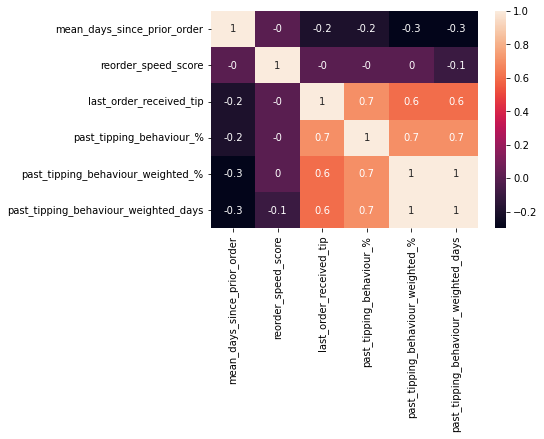

In [12]:
columns = ['mean_days_since_prior_order', 'reorder_speed_score', 'last_order_received_tip',  'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_%', 'past_tipping_behaviour_weighted_days']
newDF = orders_and_tips_x[columns]
matrix = newDF.corr().round(1)
sns.heatmap(matrix, annot=True)
plt.show()

In [13]:
#remove everything unnecessary from the above table
orders_and_tips_x = orders_and_tips_x.drop('user_id', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('order_number', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_current_order', axis=1)

orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_1', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_1', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_2', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_2', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_3', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_3', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_4', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_4', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_5', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_5', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_6', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_6', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_7', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_7', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_8', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_8', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_9', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_9', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('days_since_prior_order_10', axis=1)
orders_and_tips_x = orders_and_tips_x.drop('tip_10', axis=1)

orders_and_tips_x = orders_and_tips_x.drop('sum_tips', axis=1)

<br>
<br>
<br>

## Feature 2: New Customer

Add column <b>'new_customer'</b> to the orders table, that indicates, whether the order was placed by a new customer.

In [14]:
orders.insert(2, 'new_customer', 0)
orders.loc[orders['days_since_prior_order'].isnull(), 'new_customer'] = 1
orders.head()

,order_id,user_id,new_customer,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,0,prior,2,3,7,15.0
2,473747,1,0,prior,3,3,12,21.0
3,2254736,1,0,prior,4,4,7,29.0
4,431534,1,0,prior,5,4,15,28.0


<br>
<br>
<br>

## Feature 3: Amount of items per order

Add column <b>'amount_items_per_order'</b> to the order table, that shows the amount of items per order. This column should help to investigate, if orders with many items are more likely to be tipped.

In [15]:
order_items = op.copy()
order_items['amount_items_per_order'] = order_items.groupby("order_id")['product_id'].transform('count')

#remove everything unnecessary from the above table
order_items = order_items.drop('product_id', axis=1)
order_items = order_items.drop('add_to_cart_order', axis=1)
order_items = order_items.drop('reordered', axis=1)

order_items = order_items.drop_duplicates(keep='first')
order_items.head()

,order_id,amount_items_per_order
0,2,9
9,3,8
17,4,13
30,5,26
56,6,3


<br>
<br>
<br>

## Feature 4: Impact of product categories

Investigate, how purchasing different products affects the likelihood of tipping/non-tipping

In [16]:
# Merge tables tips_trainingsdata, orders_and_tips_1, orders_and_tips_2, orders, op, products, aisles and departments:   
aisles_departments_and_tips = tips_trainingsdata.merge(op[['order_id','product_id']]).merge(products[['product_id','aisle_id', 'department_id']]).merge(aisles).merge(departments)

In [29]:
aisles_departments_and_tips['total_amount_tips_%'] = aisles_departments_and_tips[['department_id','order_id','tip']].drop_duplicates(keep='first').groupby('department_id')['tip'].transform('mean')
aisles_departments_and_tips['total_amount_orders'] = aisles_departments_and_tips[['department_id','order_id']].drop_duplicates(keep='first').groupby('department_id')['order_id'].transform('count')
aisles_departments_and_tips['total_amount_orders_%'] = aisles_departments_and_tips[['department_id','order_id']].drop_duplicates(keep='first').groupby('department_id')['order_id'].transform('count') / aisles_departments_and_tips['order_id'].drop_duplicates(keep='first').count()
departments_and_tips = aisles_departments_and_tips[['department', 'total_amount_tips_%', 'total_amount_orders', 'total_amount_orders_%']].drop_duplicates(keep='first')
departments_and_tips = departments_and_tips.sort_values(by = 'total_amount_tips_%', axis = 0, ascending = False, inplace = False, kind = 'quicksort', na_position = 'last')
departments_and_tips.head(21)

,department,total_amount_tips_%,total_amount_orders,total_amount_orders_%
31619258,alcohol,0.811333,84689.0,0.026343
21209652,breakfast,0.538535,525188.0,0.163362
31870678,babies,0.527567,177712.0,0.055278
32399916,bulk,0.512396,33802.0,0.010514
8104145,snacks,0.509680,1391447.0,0.432815
23794798,deli,0.469344,770300.0,0.239605
28238533,international,0.466310,221537.0,0.068910
21919221,pantry,0.465184,1117892.0,0.347725
2690129,dairy eggs,0.446433,2177338.0,0.677270
32330771,missing,0.443617,59477.0,0.018501


In [30]:
aisles_departments_and_tips['total_amount_tips_%'] = aisles_departments_and_tips[['aisle_id','order_id','tip']].drop_duplicates(keep='first').groupby('aisle_id')['tip'].transform('mean')
aisles_departments_and_tips['total_amount_orders'] = aisles_departments_and_tips[['aisle_id','order_id']].drop_duplicates(keep='first').groupby('aisle_id')['order_id'].transform('count')
aisles_departments_and_tips['total_amount_orders_%'] = aisles_departments_and_tips[['aisle_id','order_id']].drop_duplicates(keep='first').groupby('aisle_id')['order_id'].transform('count') / aisles_departments_and_tips['order_id'].drop_duplicates(keep='first').count()
aisles_and_tips = aisles_departments_and_tips[['aisle', 'total_amount_tips_%', 'total_amount_orders', 'total_amount_orders_%']].drop_duplicates(keep='first')
aisles_and_tips = aisles_and_tips.sort_values(by = 'total_amount_tips_%', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
with pd.option_context("display.max_rows", None): display(aisles_and_tips)

,aisle,total_amount_tips_%,total_amount_orders,total_amount_orders_%
31693739,white wines,0.822233,25269.0,0.007860
31665637,spirits,0.820229,22918.0,0.007129
31619258,red wines,0.818304,25306.0,0.007872
31724297,beers coolers,0.815899,29750.0,0.009254
31654439,specialty wines champagnes,0.791502,9885.0,0.003075
21659098,granola,0.575648,90201.0,0.028057
10922239,trail mix snack mix,0.562335,34186.0,0.010634
21587238,breakfast bars pastries,0.555214,59233.0,0.018425
10056031,energy granola bars,0.550111,278151.0,0.086520
31870678,baby food formula,0.540475,148388.0,0.046157


**Conclusions**

The tipping behavior at the aisle level shows a similar behavior to the tipping behavior at the department level. <br>
Therefore we examine only at the department level

<br>
<br>
<b>Order contains ... :</b> Add columns, that show, if an order contains products from certain departments<br>

- <b>alcohol:</b> likelihood for tip = 1 is 81.13 %  <b>/</b> likelihood that order contains alcohol 2,63 %<br>
- <b>breakfast:</b> likelihood for tip = 1 is 53.85 %   <b>/</b> likelihood that order contains breakfast 16,34 %<br>
- <b>babies:</b> likelihood for tip = 1 is 52.75 %   <b>/</b> likelihood that order contains babies 5,53 %<br>


- <b>personal care:</b> likelihood for tip = 0 is 65,06 %   <b>/</b> likelihood that order contains personal care 9,91 %<br>
- <b>frozen:</b> likelihood for tip = 0 is 63,11 %   <b>/</b> likelihood that order contains frozen 36,74 %<br>
- <b>household:</b> likelihood for tip = 0 is 62,39 %   <b>/</b> likelihood that order contains household 14,64 %<br>
- <b>pets:</b> likelihood for tip = 0 is 62,11 %   <b>/</b> likelihood that order contains pets 1,84 %<br>
- <b>dry goods pasta:</b> likelihood for tip = 0 is 61,05 %   <b>/</b> likelihood that order contains dry goods pasta 18,60 %<br>

<b>Note:</b> If necessary, add more departments with tip=0 later on.
<br><br>

In [31]:
#new dataframe
orders_contains = orders.copy()
#new dataframe with orders, products within those orders, and departments of those products
order_departments = op[['order_id','product_id']].merge(products[['product_id','department_id']]).merge(departments)

In [32]:
#alcohol
alcohol_filter = departments[departments['department'].isin(["alcohol"])] #returns table with the desired row
alcohol_filter = alcohol_filter['department_id'] #returns desired value of above row -> department_id of "alcohol"
orders_with_alcohol = order_departments[order_departments['department_id'].isin(alcohol_filter)] #order_ids entire row
orders_with_alcohol = orders_with_alcohol['order_id'].unique() #only unique order_ids
orders_contains['contains_alcohol'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_alcohol),'contains_alcohol'] = 1

In [33]:
#breakfast
breakfast_filter = departments[departments['department'].isin(["breakfast"])] #returns table with the desired row
breakfast_filter = breakfast_filter['department_id'] #returns desired value of above row -> department_id of "breakfast"
orders_with_breakfast = order_departments[order_departments['department_id'].isin(breakfast_filter)] #order_ids entire row
orders_with_breakfast = orders_with_breakfast['order_id'].unique() #only unique order_ids
orders_contains['contains_breakfast'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_breakfast),'contains_breakfast'] = 1

In [34]:
#babies
babies_filter = departments[departments['department'].isin(["babies"])] #returns table with the desired row
babies_filter = babies_filter['department_id'] #returns desired value of above row -> department_id of "babies"
orders_with_babies = order_departments[order_departments['department_id'].isin(babies_filter)] #order_ids entire row
orders_with_babies = orders_with_babies['order_id'].unique() #only unique order_ids
orders_contains['contains_babies'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_babies),'contains_babies'] = 1

In [35]:
#personal care
personal_care_filter = departments[departments['department'].isin(["personal care"])] #returns table with the desired row
personal_care_filter = personal_care_filter['department_id'] #returns desired value of above row -> department_id of "alcohol"
orders_with_personal_care = order_departments[order_departments['department_id'].isin(personal_care_filter)] #order_ids entire row
orders_with_personal_care = orders_with_personal_care['order_id'].unique() #only unique order_ids
orders_contains['contains_personal_care'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_personal_care),'contains_personal_care'] = 1

In [36]:
#frozen
frozen_filter = departments[departments['department'].isin(["frozen"])] #returns table with the desired row
frozen_filter = frozen_filter['department_id'] #returns desired value of above row -> department_id of "frozen"
orders_with_frozen = order_departments[order_departments['department_id'].isin(frozen_filter)] #order_ids entire row
orders_with_frozen = orders_with_frozen['order_id'].unique() #only unique order_ids
orders_contains['contains_frozen'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_frozen),'contains_frozen'] = 1

In [37]:
#household
household_filter = departments[departments['department'].isin(["household"])] #returns table with the desired row
household_filter = household_filter['department_id'] #returns desired value of above row -> department_id of "alcohol"
orders_with_household = order_departments[order_departments['department_id'].isin(household_filter)]
orders_with_household = orders_with_household['order_id'].unique() #only unique order_ids
orders_contains['contains_household'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_household),'contains_household'] = 1

In [38]:
#pets
pets_filter = departments[departments['department'].isin(["pets"])] #returns table with the desired row
pets_filter = pets_filter['department_id'] #returns desired value of above row -> department_id of "alcohol"
orders_with_pets = order_departments[order_departments['department_id'].isin(pets_filter)]
orders_with_pets = orders_with_pets['order_id'].unique() #only unique order_ids
orders_contains['contains_pets'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_pets),'contains_pets'] = 1

In [39]:
#dry goods pasta
dry_goods_pasta_filter = departments[departments['department'].isin(["dry goods pasta"])] #returns table with the desired row
dry_goods_pasta_filter = dry_goods_pasta_filter['department_id'] #returns desired value of above row -> department_id of "alcohol"
orders_with_dry_goods_pasta = order_departments[order_departments['department_id'].isin(dry_goods_pasta_filter)]
orders_with_dry_goods_pasta = orders_with_dry_goods_pasta['order_id'].unique() #only unique order_ids
orders_contains['contains_dry_goods_pasta'] = 0
orders_contains.loc[orders_contains['order_id'].isin(orders_with_dry_goods_pasta),'contains_dry_goods_pasta'] = 1

In [40]:
#remove everything unnecessary from the above table
orders_contains = orders_contains.drop('user_id', axis=1)
orders_contains = orders_contains.drop('new_customer', axis=1)
orders_contains = orders_contains.drop('order_number', axis=1)
orders_contains = orders_contains.drop('order_dow', axis=1)
orders_contains = orders_contains.drop('order_hour_of_day', axis=1)
orders_contains = orders_contains.drop('days_since_prior_order', axis=1)
orders_contains.head()

,order_id,eval_set,contains_alcohol,contains_breakfast,contains_babies,contains_personal_care,contains_frozen,contains_household,contains_pets,contains_dry_goods_pasta
0,2539329,prior,0,0,0,0,0,1,0,0
1,2398795,prior,0,1,0,0,0,0,0,0
2,473747,prior,0,0,0,0,0,0,0,0
3,2254736,prior,0,0,0,0,0,1,0,0
4,431534,prior,0,0,0,0,0,0,0,0


One of the best places to start understanding the relationship between the independent variable is the correlation between the variables. In the below code, heatmap of the correlation is plotted using .corr method in Pandas. The Correlation heatmap, as shown below, provides us with a visual depiction of the relationship between the variables.  

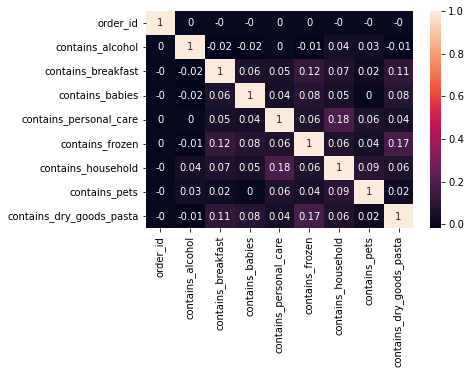

In [41]:
matrix = orders_contains.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

#### Ten most bought Products

<AxesSubplot:xlabel='product_name'>

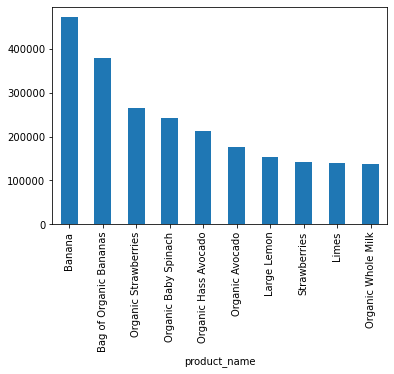

In [42]:
newDF= pd.merge(aisles_departments_and_tips, products, on = "product_id", how = "inner")
newDF.groupby('product_name')['order_id'].count().sort_values(ascending=False).head(10).plot(kind='bar')

#### Ten most tipped Products

<AxesSubplot:xlabel='product_name'>

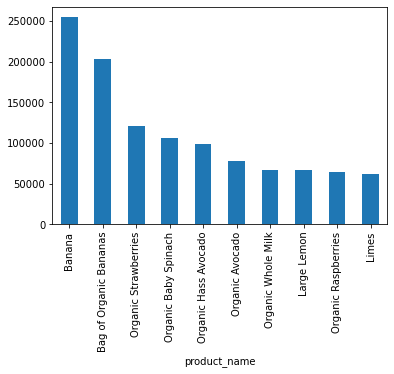

In [43]:
newDF.groupby('product_name')['tip'].apply(lambda x: (x==1).sum()).sort_values(ascending=False).head(10).plot(kind='bar')

<br>
<br>

**Conclusions**

In a next step it would make sense to add contains_bananas as well.

<br>
<br>
<br>

## Final Dataframe

all data in one table -> Trainings- and Testdata

In [44]:
#merge everything into a big table 
orders_extended = tips_trainingsdata.merge(orders_and_tips_x)
orders_extended = orders_extended.merge(orders[['order_id', 'order_number', 'new_customer', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']])
orders_extended = orders_extended.merge(order_items)
orders_extended = orders_extended.merge(orders_contains)
orders_extended = orders_extended[['order_id', 'new_customer', 'tip', 'last_order_received_tip', 'order_number', 'amount_orders_in_this_batch', 'sum_days_since_prior_order', 'mean_days_since_prior_order', 'days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_breakfast', 'contains_babies', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']]
orders_extended = orders_extended.sort_values(by = 'order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# replace NaN values through 0
orders_extended = orders_extended.fillna(0)
# RAM optimization
orders_extended['last_order_received_tip'] = orders_extended['last_order_received_tip'].astype(int) 
orders_extended['sum_days_since_prior_order'] = orders_extended['sum_days_since_prior_order'].astype(int)
orders_extended['mean_days_since_prior_order'] = orders_extended['mean_days_since_prior_order'].astype(int) 
orders_extended['days_since_prior_order'] = orders_extended['days_since_prior_order'].astype(int) 
#orders_extended.head()
with pd.option_context('display.max_rows', 10, 'display.max_columns', 33): display(orders_extended)
#order_dow ---> day of the week / weekday 

,order_id,new_customer,tip,last_order_received_tip,order_number,amount_orders_in_this_batch,sum_days_since_prior_order,mean_days_since_prior_order,days_since_prior_order,reorder_speed_score,past_tipping_behaviour_%,past_tipping_behaviour_weighted_%,past_tipping_behaviour_weighted_days,order_dow,order_hour_of_day,amount_items_per_order,contains_alcohol,contains_breakfast,contains_babies,contains_personal_care,contains_frozen,contains_household,contains_pets,contains_dry_goods_pasta
3153247,2,0,0,0,3,2,28,14,8,0.571429,0.0,0.00,0.000000,5,9,9,0,0,0,0,0,0,0,0
3211222,3,0,0,1,16,10,65,6,12,1.846154,0.5,1.51,1.251920,5,17,8,0,0,0,0,0,0,0,0
2779488,4,0,1,1,36,10,63,6,7,1.111111,1.0,4.51,4.263074,1,9,13,0,1,0,1,0,0,0,0
2437252,5,0,1,1,42,10,64,6,9,1.406250,1.0,4.51,3.900156,6,16,26,0,0,0,1,0,1,0,1
348269,6,0,0,0,4,3,63,21,30,1.428571,0.0,0.00,0.000000,1,12,3,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701282,3421079,0,1,0,6,5,91,18,0,0.000000,0.2,0.00,0.001098,1,13,1,0,0,0,1,0,0,0,0
824599,3421080,0,1,0,2,1,2,2,2,1.000000,0.0,0.00,0.000000,1,11,9,0,0,0,0,1,0,0,0
1832649,3421081,1,0,0,1,0,0,0,0,0.000000,0.0,0.00,0.000000,3,11,7,0,0,0,0,0,0,0,0
2728068,3421082,0,0,1,23,10,76,7,4,0.526316,0.3,2.00,1.988173,2,18,7,0,1,0,0,0,0,0,0


all data in one table -> Submission Data (data, that should be submitted as csv.file)

In [8]:
#merge everything into a big table 
orders_extended_submission_csv = tips_testdata.merge(orders_and_tips_x)
orders_extended_submission_csv = orders_extended_submission_csv.merge(orders[['order_id', 'order_number', 'new_customer', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']])
orders_extended_submission_csv = orders_extended_submission_csv.merge(order_items)
orders_extended_submission_csv = orders_extended_submission_csv.merge(orders_contains)
orders_extended_submission_csv = orders_extended_submission_csv[['order_id', 'new_customer', 'tip', 'last_order_received_tip', 'order_number', 'amount_orders_in_this_batch', 'sum_days_since_prior_order', 'mean_days_since_prior_order', 'days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_breakfast', 'contains_babies', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']]
orders_extended_submission_csv = orders_extended_submission_csv.sort_values(by = 'order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# replace NaN values through 0
orders_extended_submission_csv = orders_extended_submission_csv.fillna(0)
# RAM optimization
orders_extended_submission_csv['last_order_received_tip'] = orders_extended_submission_csv['last_order_received_tip'].astype(int) 
orders_extended_submission_csv['sum_days_since_prior_order'] = orders_extended_submission_csv['sum_days_since_prior_order'].astype(int)
orders_extended_submission_csv['mean_days_since_prior_order'] = orders_extended_submission_csv['mean_days_since_prior_order'].astype(int) 
orders_extended_submission_csv['days_since_prior_order'] = orders_extended_submission_csv['days_since_prior_order'].astype(int) 

NameError: name 'orders_and_tips_x' is not defined

In [7]:
orders_extended_submission_csv.head()

NameError: name 'orders_extended_submission_csv' is not defined

<br>
<br>
<br>


## Data Analytics

### VIF Factor

One of the cornerstones for the success of the Supervised machine learning algorithms is selecting the right set of the independent variable for the learning phase. VIF quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate’s standard deviation) of an estimated regression coefficient is increased because of collinearity.

https://en.wikipedia.org/wiki/Variance_inflation_factor

In [46]:
newDF = orders_extended[['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']]

vif = pd.DataFrame()
vif["features"] = newDF.columns
vif["vif_Factor"] = [variance_inflation_factor(newDF.values, i) for i in range(newDF.shape[1])]
print(vif)

                                features  vif_Factor
0                           new_customer    1.536921
1                last_order_received_tip    3.479747
2            mean_days_since_prior_order   13.392624
3                 days_since_prior_order   16.993481
4                    reorder_speed_score   10.695307
5               past_tipping_behaviour_%    7.068669
6      past_tipping_behaviour_weighted_%   60.847333
7   past_tipping_behaviour_weighted_days   57.049877
8                              order_dow    2.669071
9                      order_hour_of_day    7.609479
10                amount_items_per_order    3.844558
11                      contains_alcohol    1.049661
12                contains_personal_care    1.164777
13                       contains_frozen    1.855887
14                    contains_household    1.246974
15                         contains_pets    1.032061
16              contains_dry_goods_pasta    1.423539


Since it is recommended to remove all variables with a value higher than 10, the variable 'past_tipping_behaviour_weighted_%' was removed and the procedure was run again:

In [47]:
newDF = orders_extended[['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']]

vif = pd.DataFrame()
vif["features"] = newDF.columns
vif["vif_Factor"] = [variance_inflation_factor(newDF.values, i) for i in range(newDF.shape[1])]
print(vif)

                                features  vif_Factor
0                           new_customer    1.530784
1                last_order_received_tip    3.464947
2            mean_days_since_prior_order   13.217939
3                 days_since_prior_order   16.934958
4                    reorder_speed_score   10.223806
5               past_tipping_behaviour_%    6.960317
6   past_tipping_behaviour_weighted_days    4.643795
7                              order_dow    2.665810
8                      order_hour_of_day    7.545998
9                 amount_items_per_order    3.844409
10                      contains_alcohol    1.049659
11                contains_personal_care    1.164770
12                       contains_frozen    1.855734
13                    contains_household    1.246972
14                         contains_pets    1.032060
15              contains_dry_goods_pasta    1.423536


Since it is recommended to remove all variables with a value higher than 10, the variable 'days_since_prior_order' was removed and the procedure was run again:

In [48]:
newDF = orders_extended[['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']]

vif = pd.DataFrame()
vif["features"] = newDF.columns
vif["vif_Factor"] = [variance_inflation_factor(newDF.values, i) for i in range(newDF.shape[1])]
print(vif)

                                features  vif_Factor
0                           new_customer    1.396875
1                last_order_received_tip    3.464397
2            mean_days_since_prior_order    3.104292
3                    reorder_speed_score    3.371532
4               past_tipping_behaviour_%    6.924590
5   past_tipping_behaviour_weighted_days    4.612194
6                              order_dow    2.600050
7                      order_hour_of_day    6.332664
8                 amount_items_per_order    3.806882
9                       contains_alcohol    1.049533
10                contains_personal_care    1.164689
11                       contains_frozen    1.854939
12                    contains_household    1.246823
13                         contains_pets    1.032060
14              contains_dry_goods_pasta    1.423472


All these variables now have a VIF factor below 10 and are therefore suitable for the following ML models.

### Heatmap

One of the best places to start understanding the relationship between the independent variable is the correlation between the variables. In the below code, heatmap of the correlation is plotted using .corr method in Pandas. The Correlation heatmap, as shown below, provides us with a visual depiction of the relationship between the variables.  

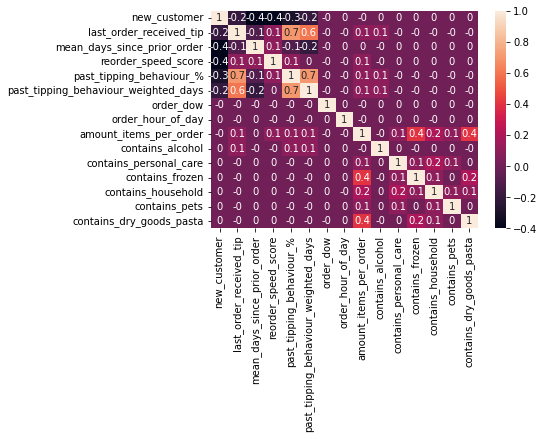

In [49]:
columns = ['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta']
newDF = orders_extended[columns]
matrix = newDF.corr().round(1)
sns.heatmap(matrix, annot=True)
plt.show()

<br>
<br>
<br>

# Preparation for ML

## RAM Optimization

In [50]:
del(aisles)
del(aisles_and_tips)
del(aisles_departments_and_tips)
del(departments)
del(departments_and_tips)
del(op)
del(opp)
del(opt)
del(order_departments)
del(order_items)
del(orders)
del(orders_and_tips)
del(orders_and_tips__1)
del(orders_and_tips__2)
del(orders_and_tips__3)
del(orders_and_tips__4)
del(orders_and_tips__5)
del(orders_and_tips__6)
del(orders_and_tips__7)
del(orders_and_tips__8)
del(orders_and_tips__9)
del(orders_and_tips__10)
del(orders_and_tips__11)
del(orders_contains)
del(orders_with_alcohol)
del(orders_with_babies)
del(orders_with_breakfast)
del(orders_with_dry_goods_pasta)
del(orders_with_frozen)
del(orders_with_household)
del(orders_with_personal_care)
del(orders_with_pets)
del(products)

## Split into Train, Test

Trainings- and Testdata

In [52]:
columns = ['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household', 'contains_pets', 'contains_dry_goods_pasta', 'tip']

reducedDF = orders_extended[columns]

train, test = train_test_split(reducedDF, test_size=0.2)

X_train = train.drop('tip', axis=1) # all but the last column which is the target variable
y_train = train['tip']
X_test  = test.drop('tip', axis=1)
y_test  = test['tip']

Submission Data

In [53]:
columns = ['new_customer', 'last_order_received_tip', 'mean_days_since_prior_order', 'reorder_speed_score', 'past_tipping_behaviour_%', 'past_tipping_behaviour_weighted_days', 'order_dow', 'order_hour_of_day', 'amount_items_per_order', 'contains_alcohol', 'contains_personal_care', 'contains_frozen', 'contains_household','contains_pets', 'contains_dry_goods_pasta', 'tip']
reducedDF_submission =  orders_extended_submission_csv[columns]

X_train_submission = reducedDF.drop('tip', axis=1) # all but the last column which is the target variable
y_train_submission = reducedDF['tip']
X_test_submission  = reducedDF_submission.drop('tip', axis=1)
y_test_submission  = reducedDF_submission['tip']



# HINZUFÜGEN DER "tip_testdaten_mit_target_werten.csv" ALS y_test_submission 

#real world data with the correct values
tip_testdaten_mit_target_werten = pd.read_csv('Data/tip_testdaten_mit_target_werten.csv') 
tip_testdaten_mit_target_werten = tip_testdaten_mit_target_werten.sort_values(by = 'order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

y_test_submission  = tip_testdaten_mit_target_werten['tip']
#y_test_submission  = reducedDF_submission['tip']

## Normalize

In [54]:
scaler = StandardScaler() # Normiert alles auf Standardabweichung 1 und Mittelwert 0
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

X_train_submission  = pd.DataFrame(scaler.fit_transform(X_train_submission), columns = X_train_submission.columns)
X_test_submission  = pd.DataFrame(scaler.transform(X_test_submission), columns = X_test_submission.columns)

# Machine Learning Models

## Simple Benchmark

In order to have a primitive comparison value for the following models, it is calculated here how high the accuracy is if one always estimates yes and always no, respectively. 

In [55]:
orders_extended['tip'].value_counts(normalize=True) * 100

0    57.823728
1    42.176272
Name: tip, dtype: float64

## DecisionTreeClassifier without Cross Validation

In [56]:
dtc = tree.DecisionTreeClassifier(max_depth=12) 

dtc = dtc.fit(X=X_train, y=y_train)
print("Accuracy on training   set= ", dtc.score(X_train, y_train))
print("Accuracy on validation set= ", dtc.score(X_test, y_test))
#fig, ax = plt.subplots(figsize=(15, 10))  # whatever size you want
#tree.plot_tree(dtc, feature_names = columns[:-1], filled=True) 
#plt.show()

Accuracy on training   set=  0.7441843556064993
Accuracy on validation set=  0.7407099809479373


In [57]:
#Submission
ml_submission_a = tree.DecisionTreeClassifier(max_depth=12) 
ml_submission_a = ml_submission_a.fit(X_train_submission, y_train_submission)

#from here standardized code
predicted_values_for_submission_a = ml_submission_a.predict(X_test_submission)

# HERE IS THE ERROR (see code below)! --> the tips_testdata are not sorted by the order_id, while the data,
#which were given in the model are sorted by the order_id !!!

#tips_testdata['tip'] = predicted_values_for_submission_a
#tips_testdata.loc[tips_testdata['tip'] == 0,'tip'] = 'F'
#tips_testdata.loc[tips_testdata['tip'] == 1,'tip'] = 'T'
#tips_testdata.to_csv('data_science_2_Benny_Lara_Pauline_DecisionTreeClassifier')


# corrected code:
tips_testdata = tips_testdata.sort_values(by = 'order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
tips_testdata['tip'] = predicted_values_for_submission_a
tips_testdata.loc[tips_testdata['tip'] == 0,'tip'] = 'F'
tips_testdata.loc[tips_testdata['tip'] == 1,'tip'] = 'T'
tips_testdata.to_csv('data_science_2_Benny_Lara_Pauline_DecisionTreeClassifier')


# CHECKING THE MODEL ON THE REAL DATA
print("Accuracy on training   set= ", ml_submission_a.score(X_train_submission, y_train_submission))
print("Accuracy on validation set= ", ml_submission_a.score(X_test_submission, y_test_submission))

In [6]:
tips_testdata = tips_testdata.sort_values(by = 'order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

tips_testdata.head()

,order_id,tip
71234,1,NaN
50471,36,NaN
27223,38,NaN
11018,96,NaN
35857,98,NaN


## DecisionTreeClassifier with Cross Validation

In [58]:
dtcv = tree.DecisionTreeClassifier(max_depth=12)
scores = cross_val_score(dtcv, X=X_train, y=y_train, cv=10)
print('Average Score: ', scores.mean())
print('Scores:', scores)

Average Score:  0.7401297644187872
Scores: [0.73895952 0.74155683 0.74067032 0.74146351 0.73979159 0.73766865
 0.74099693 0.74034371 0.7387379  0.74110868]


## Random Forest without Cross Validation

In [59]:
rf = RandomForestClassifier(max_depth = 12) 
rf.fit(X=X_train, y=y_train)
print("Accuracy = ", rf.score(X_test, y_test))

Accuracy =  0.7419433103930946


In [ ]:
#Submission
ml_submission_b = RandomForestClassifier(max_depth = 12) 
ml_submission_b = ml_submission_b.fit(X=X_train_submission, y=y_train_submission)

#from here standardized code
predicted_values_for_submission_b = ml_submission_b.predict(X_test_submission)
tips_testdata['tip'] = predicted_values_for_submission_b
tips_testdata.loc[tips_testdata['tip'] == 0,'tip'] = 'F'
tips_testdata.loc[tips_testdata['tip'] == 1,'tip'] = 'T'
tips_testdata.to_csv('data_science_2_Benny_Lara_Pauline_Random Forest')

## Random Forest with Cross Validation

In [ ]:
rfc = RandomForestClassifier(max_depth = 12)
scores = cross_val_score(rfc, X=X_train, y=y_train, cv=10)
print('Average Score: ', scores.mean())

## XGB without Cross Validation

In [ ]:
xgb = XGBClassifier(max_depth = 12)
xgb.fit(X=X_train, y=y_train, eval_metric='rmse')
print("Accuracy = ", xgb.score(X_test, y_test))

In [ ]:
#Submission
ml_submission_c = XGBClassifier(max_depth = 12)
ml_submission_c = ml_submission_c.fit(X=X_train_submission, y=y_train_submission, eval_metric='rmse')

#ab hier standardisierter Code
predicted_values_for_submission_c = ml_submission_c.predict(X_test_submission)
tips_testdata['tip'] = predicted_values_for_submission_c
tips_testdata.loc[tips_testdata['tip'] == 0,'tip'] = 'F'
tips_testdata.loc[tips_testdata['tip'] == 1,'tip'] = 'T'
tips_testdata.to_csv('data_science_2_Benny_Lara_XGB')

## XGB with Cross Validation

In [ ]:
xgbc = XGBClassifier(max_depth = 12)
scores = cross_val_score(xgbc, X=X_train, y=y_train, cv=10)
print('Average Score: ', scores.mean())

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,10,), max_iter=3000) # Add parameters to specify the architecture: 2 hidden layers with 10 neurone each
# Documentation see: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

mlp = mlp.fit(X_train,y_train)
print("Accuracy on training set= ", mlp.score(X_train, y_train))
print("Accuracy on validation set= ", mlp.score(X_test, y_test))

In [ ]:
#Submission
ml_submission_d = MLPClassifier(hidden_layer_sizes=(10,10,), max_iter=3000)
ml_submission_d = ml_submission_d.fit(X=X_train_submission, y=y_train_submission, eval_metric='rmse')

#ab hier standardisierter Code
predicted_values_for_submission_d = ml_submission_d.predict(X_test_submission)
tips_testdata['tip'] = predicted_values_for_submission_d
tips_testdata.loc[tips_testdata['tip'] == 0,'tip'] = 'F'
tips_testdata.loc[tips_testdata['tip'] == 1,'tip'] = 'T'
tips_testdata.to_csv('data_science_2_Benny_Lara_MLP')

## Did not work

### KNeighborsClassifier

In [ ]:
#knc =  KNeighborsClassifier(n_neighbors=3) # Add parameter to set k, i.e. the number of neighbors
#knc = knc.fit(X_train,y_train)
#print("Accuracy on training set= ", knc.score(X_train, y_train))
#print("Accuracy on test set= ", knc.score(X_test, y_test))

### Linear perceptron classifier 

In [ ]:
#lp = Perceptron()
#lp = lp.fit(X_train,y_train)
#print("Accuracy on training set= ", lp.score(X_train, y_train))
#print("Accuracy on test set= ", lp.score(X_test, y_test))

<br>
<br>
<br>

## key results, lessons learned and achievements

<br>

+ One should not unknowingly use the target variable (tips) indirectly to calculate the input variables that one later wants to transfer to the machine learning model. This was a problem for us when we created the feature for the past tipping behavior. This unintentionally tells the machine learning model the result - which becomes problematic as soon as the model is supposed to calculate actual future data. With error, the forecast accuracy on the training set was about 89%, after correction of the corresponding feature 74%. The forecast accuracy on the validation set is 78,6%


+ One should try to avoid including future values in the calculation, because this also trains the machine learning model in the wrong direction. This was also a problem with Past Tipping Behaviour.



+ After correcting the model and fixing the bugs, we didn't have as much time to investigate further. As a first step, we checked whether we could find products for which a tip was given particularly frequently. This was not promising, however, as it tended to worsen our forecast. It would be to check if we simply chose the wrong products there and if one can find better products related to this. For example, by selecting the 100 most common products and examining which of them have the highest tip rate.


+ The section with the departments could also be improved. Other departments to look for are: Bulk, Snacks, Deli, International, Pantry


+ One could also examine whether the weight of the order also influences the betting behavior of the users. For this, however, new data would have to be collected from the company, since the weight of the individual products was not given.


+ We also noticed that the order_id doesn't sort the orders in the right order. The order_id seems to be randomly assigned to anonymize the data. Therefore, it is not optimal that we sorted the orders by the order_id for our training and testing split. It would be better if you could sort the orders by date, for example, or if you could modify the test data to only contain the user's most recent order.


+ As a final point, we would recommend that the company not only investigate whether someone has tipped, but also how much the tip was. A customer who tips only a very small amount, for example €1, may be less valuable than a customer who tips €12.